In [1]:
try:
    __IPYTHON__
    is_notebook = True
    print('Notebook mode')
except NameError:
    is_notebook = False
    print('Script mode')

Notebook mode


# Pip Install

In [2]:
if is_notebook:
    !pip install boto3 astropy sfdmap progressbar2 GPUtil parse

# Initialization

In [3]:
import GPUtil
print('GPUs:\n{0}'.format('\n'.join(['('+str(i+1)+')\t'+gpu.name+'\t-\t{:.2f}GB'.format(gpu.memoryFree/1e3) for i,gpu in enumerate(GPUtil.getGPUs())])))
N_GPUs = len(GPUtil.getGPUs())

# setting environ variables using !
if is_notebook:
    !export TF_GPU_THREAD_MODE="gpu_private"
    if N_GPUs>1:
        if N_GPUs==2:
            !export TF_MIN_GPU_MULTIPROCESSOR_COUNT=2
            !export CUDA_VISIBLE_DEVICES="0,1"
        if N_GPUs==3:
            !export TF_MIN_GPU_MULTIPROCESSOR_COUNT=3
            !export CUDA_VISIBLE_DEVICES="0,1,2"
        if N_GPUs==4:
            !export TF_MIN_GPU_MULTIPROCESSOR_COUNT=4
            !export CUDA_VISIBLE_DEVICES="0,1,2,3"
        if N_GPUs==5:
            !export TF_MIN_GPU_MULTIPROCESSOR_COUNT=5
            !export CUDA_VISIBLE_DEVICES="0,1,2,3,4"
        if N_GPUs==6:
            !export TF_MIN_GPU_MULTIPROCESSOR_COUNT=6
            !export CUDA_VISIBLE_DEVICES="0,1,2,3,4,5"
        if N_GPUs==7:
            !export TF_MIN_GPU_MULTIPROCESSOR_COUNT=7
            !export CUDA_VISIBLE_DEVICES="0,1,2,3,4,5,6"
        if N_GPUs==8:
            !export TF_MIN_GPU_MULTIPROCESSOR_COUNT=8
            !export CUDA_VISIBLE_DEVICES="0,1,2,3,4,5,6,7"

# set environ variables using os.environ
import os 
if N_GPUs>1:
    os.environ["TF_MIN_GPU_MULTIPROCESSOR_COUNT"]=str(N_GPUs)
    os.environ["CUDA_VISIBLE_DEVICES"]=','.join([str(i) for i in range(N_GPUs)])
os.environ["TF_GPU_THREAD_MODE"]="gpu_private"

# make sure tensorflow detect the GPUs
import tensorflow as tf
assert len(tf.config.list_physical_devices('GPU'))==N_GPUs, 'Not all GPUs are available!'

GPUs:
(1)	Tesla V100-SXM2-32GB	-	32.51GB


2023-02-18 21:09:54.703834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 21:09:55.151871: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-18 21:09:57.366312: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-18 21:09:57.397594: W tensorflow/

In [4]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
import boto3
from matplotlib import pyplot as plt
import time

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_home_dir_path = os.path.expanduser("~")
local_work_dir_path = os.path.join(local_home_dir_path, 'thesis2')
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3-west.nrp-nautilus.io'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = os.path.join(prefix, 'thesis2')
s3_data_dir_path = os.path.join(s3_work_dir_path , 'data')
s3_models_dir_path = os.path.join(s3_work_dir_path , 'models')
s3_final_table_csv_path = os.path.join(s3_data_dir_path, 'SDSS_DR16_all.csv')

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig
from s3 import log_s3, s3_save_TF_model, s3_load_TF_model
from NN import DistanceLayer, SiameseModel, DistillationDataGenerator, L1, L2

# Load Models

In [5]:
# Load NN
batch_size = 128
NN = s3_load_TF_model(s3_client = s3_client,
                      bucket_name = bucket_name,
                      path_in_bucket = 'almogh/thesis2/models/NN/train/after_50_epochs/model',
                      model_name = 'model',
                      custom_objects = {'DistanceLayer': DistanceLayer, 'L1':L1, 'L2':L2, 'SiameseModel':SiameseModel})

loading from uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_50_epochs/model
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-SXM2-32GB, compute capability 7.0


2023-02-18 21:10:02.626732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 21:10:04.060334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30972 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


In [6]:
# Load SmallRF
SmallRF = from_s3_pkl(s3_client = s3_client,
                      bucket_name = bucket_name,
                      path_in_bucket = 'almogh/thesis2/models/SmallRF/train/rf.pkl')

loading from uri: s3://tau-astro/almogh/thesis2/models/SmallRF/train/rf.pkl


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.1.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
# Load BigRF
BigRF = from_s3_pkl(s3_client = s3_client,
                      bucket_name = bucket_name,
                      path_in_bucket = 'almogh/thesis2/models/BigRF/train/rf.pkl')

loading from uri: s3://tau-astro/almogh/thesis2/models/BigRF/train/rf.pkl


# Infer

In [8]:
data = {
    'NN_val':'almogh/thesis2/data/NN/val',
    'SmallRF_val':'almogh/thesis2/data/SmallRF/val',
    'SmallRF_test':'almogh/thesis2/data/SmallRF/test-topSNR'
       }
SNRs = np.array([2,4,6,8,10,15,20,25,30,40,100,np.inf])

====== data:NN_val =====
loading from uri: s3://tau-astro/almogh/thesis2/data/NN/val/spec.npy
----- SNR:2.0 -----
creating a noisy copy
Calculating distance vector for NN


2023-02-18 21:10:21.548001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204


8/8 [==============================] - 5s 62ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.1s


  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    5.3s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    0.3s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


----- SNR:4.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 29ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.4s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


Calculating distance vector for BigRF
  Applying forest to results... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.5s remaining:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


----- SNR:6.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 27ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished


  Calculating similarity matrix... 
Calculating distance vector for BigRF
  Applying forest to results... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished


----- SNR:8.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 26ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Max leaf index: 
74
  Calculating real leafs... 
  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished


Calculating distance vector for BigRF
  Applying forest to results... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.3s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


----- SNR:10.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 23ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:    0.3s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished


Calculating distance vector for BigRF
  Applying forest to results... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.3s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished


----- SNR:15.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 22ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:20.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:25.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:30.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 387 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:40.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:100.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:inf -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Plotting
saving to uri: s3://tau-astro/almogh/thesis2/eval/DistToNoisySelf/NN_val_alt.png
====== data:SmallRF_val =====
loading from uri: s3://tau-astro/almogh/thesis2/data/SmallRF/val/spec.npy
----- SNR:2.0 -----
creating a noisy copy
Calculating distance vector for NN
9/9 [==============================] - 0s 30ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 387 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:4.0 -----
creating a noisy copy
Calculating distance vector for NN
9/9 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 387 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:6.0 -----
creating a noisy copy
Calculating distance vector for NN
9/9 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:8.0 -----
creating a noisy copy
Calculating distance vector for NN
9/9 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:10.0 -----
creating a noisy copy
Calculating distance vector for NN
9/9 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:15.0 -----
creating a noisy copy
Calculating distance vector for NN
9/9 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s


  Max leaf index: 
74
  Calculating real leafs... 
  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:20.0 -----
creating a noisy copy
Calculating distance vector for NN
9/9 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:25.0 -----
creating a noisy copy
Calculating distance vector for NN
9/9 [==============================] - 0s 21ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:30.0 -----
creating a noisy copy
Calculating distance vector for NN
9/9 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:40.0 -----
creating a noisy copy
Calculating distance vector for NN
9/9 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:100.0 -----
creating a noisy copy
Calculating distance vector for NN
9/9 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:inf -----
creating a noisy copy
Calculating distance vector for NN
9/9 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Plotting
saving to uri: s3://tau-astro/almogh/thesis2/eval/DistToNoisySelf/SmallRF_val_alt.png
====== data:SmallRF_test =====
loading from uri: s3://tau-astro/almogh/thesis2/data/SmallRF/test-topSNR/spec.npy
----- SNR:2.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 387 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:4.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:6.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:8.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 21ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:10.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:15.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:20.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:25.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:30.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
74
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:40.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s


  Max leaf index: 
74
  Calculating real leafs... 
  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:100.0 -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 20ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
73
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


----- SNR:inf -----
creating a noisy copy
Calculating distance vector for NN
8/8 [==============================] - 0s 21ms/step
Calculating distance vector for SmallRF
  Applying forest to results... 
  Max leaf index: 
73
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 437 out of 500 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Calculating distance vector for BigRF
  Applying forest to results... 
  Max leaf index: 
360
  Calculating real leafs... 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.1s


  Calculating similarity matrix... 


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished


Plotting
saving to uri: s3://tau-astro/almogh/thesis2/eval/DistToNoisySelf/SmallRF_test_alt.png


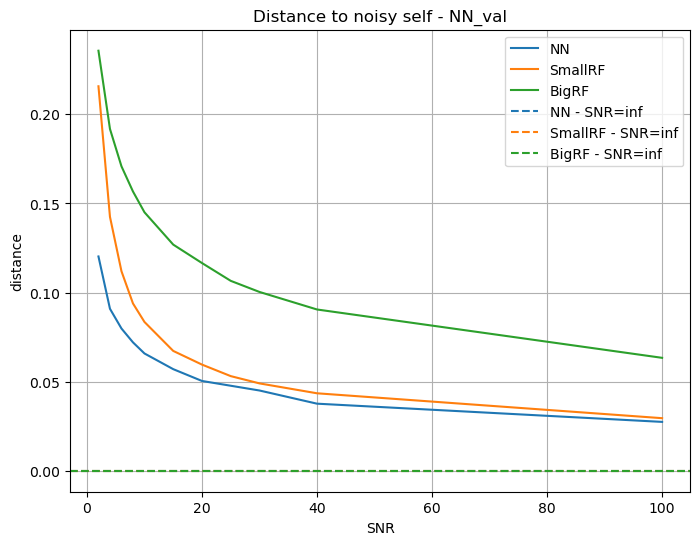

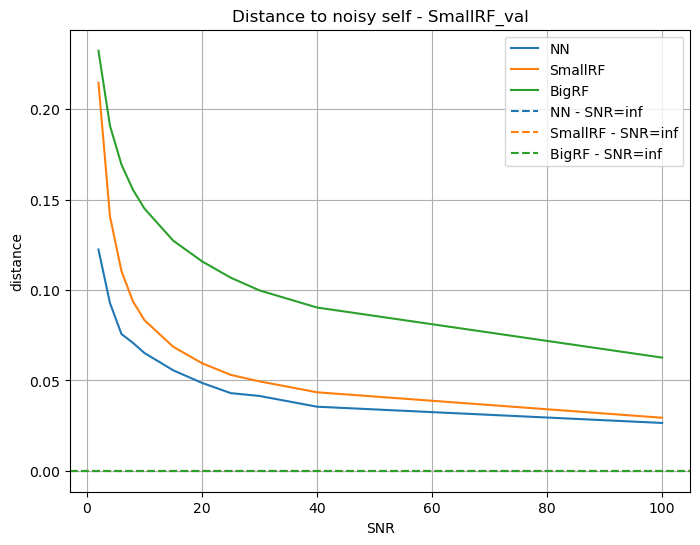

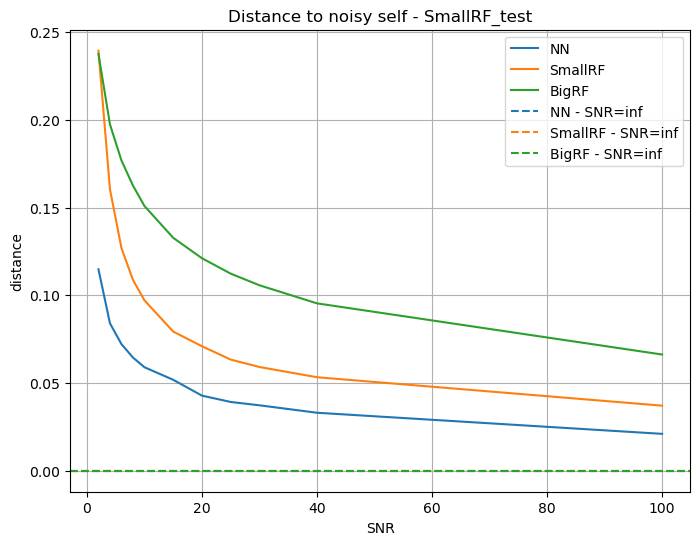

In [9]:
from uRF_SDSS import calcDisMat
for data_name, data_dir in data.items():
    print('====== data:{0} ====='.format(data_name))
    
    X = from_s3_npy(s3_client = s3_client,
                    bucket_name = bucket_name,
                    path_in_bucket = os.path.join(data_dir, 'spec.npy'))
    
    D_NN = np.zeros(shape=(len(SNRs),X.shape[0]))
    D_SmallRF = np.zeros(shape=(len(SNRs),X.shape[0]))
    D_BigRF = np.zeros(shape=(len(SNRs),X.shape[0]))

    for i,snr in enumerate(SNRs):
        print('----- SNR:{0} -----'.format(snr))
        
        print('creating a noisy copy')
        X_noisy = X.copy()
        if snr!=np.inf:
            N_std_x = np.sqrt((np.std(X,axis=1)**2)/snr)
            X_noisy += N_std_x.reshape(-1,1)*np.random.randn(X.shape[0],X.shape[1])
        
        print('Calculating distance vector for NN')
        D_NN[i] = NN.siamese_network.predict([X,X_noisy], batch_size=batch_size)
        
        print('Calculating distance vector for SmallRF')
        D_tmp = calcDisMat(SmallRF, np.concatenate([X, X_noisy]))
        D_SmallRF[i] = np.diag(D_tmp, X.shape[0])
        
        print('Calculating distance vector for BigRF')
        D_tmp = calcDisMat(BigRF, np.concatenate([X, X_noisy]))
        D_BigRF[i] = np.diag(D_tmp, X.shape[0])
        
    print('Plotting')

    d_NN = np.mean(D_NN, axis=1)
    d_SmallRF = np.mean(D_SmallRF, axis=1)
    d_BigRF = np.mean(D_BigRF, axis=1)

    fig,ax = plt.subplots(figsize=(8,6))

    ax.plot(SNRs[:-1], d_NN[:-1], 'tab:blue', label='NN')
    ax.plot(SNRs[:-1], d_SmallRF[:-1], 'tab:orange', label='SmallRF')
    ax.plot(SNRs[:-1], d_BigRF[:-1], 'tab:green', label='BigRF')

    ax.axhline(y=d_NN[-1], color='tab:blue', linestyle='--', label='NN - SNR=inf')
    ax.axhline(y=d_SmallRF[-1], color='tab:orange', linestyle='--', label='SmallRF - SNR=inf')
    ax.axhline(y=d_BigRF[-1], color='tab:green', linestyle='--', label='BigRF - SNR=inf')

    ax.set_xlabel('SNR')
    ax.set_ylabel('distance')
    ax.set_title('Distance to noisy self - '+data_name)
    ax.legend()
    plt.grid()

    to_s3_fig(fig, s3_client, bucket_name, os.path.join('almogh/thesis2/eval/DistToNoisySelf','{0}.png'.format(data_name)))